In [218]:
import pymongo
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from kubernetes import client,config,watch

In [219]:
mongoclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = mongoclient['resource']

In [220]:
collist = db.list_collection_names()
collist

['usage', 'requests']

In [221]:
# convert cpu unit 'n' to 'm'
def convert_cpu(x):
    if x != 0:
        if x[-1] == 'n':
            return round(int(x[:-1])/1000000)
        elif x[-1] == 'm':
            return int(x[:-1])
    else:
        return 0
    
# convert memory unit 'k' and 'Ki' to 'Mi'
# 1k = 1000/1024 Ki = 1000/1024**2 Mi
def convert_mem(x):
    if x != 0:
        if x[-1] == 'k':
            return round(int(x[:-1])*1000/1024**2)
        elif x[-2:] == 'Ki':
            return round(int(x[:-2])/1024)
        elif x[-2:] == 'Mi':
            return int(x[:-2])
    else:
        return 0

In [222]:
record = {}
for col in collist:
    record[col] = pd.DataFrame(list(db[col].find()))
    # convert timestamp to time
    record[col]['time'] = pd.to_datetime(record[col]['time'],unit='s').round('1s')
    record[col]['cpu'] = record[col]['cpu'].apply(lambda x: convert_cpu(x))
    record[col]['cpu'] = record[col]['cpu'].fillna(0)
    record[col]['memory'] = record[col]['memory'].apply(lambda x: convert_mem(x))


In [223]:
request = record['requests']
usage = record['usage']
request

,_id,time,cpu,memory,pod_name
0,60a2781288a2a0ed6c9c8017,2021-05-17 14:05:07,100,50,vpa-589964f979-6mk5t
1,60a2781288a2a0ed6c9c8018,2021-05-17 14:05:07,100,50,vpa-589964f979-xq625
2,60a2781388a2a0ed6c9c8019,2021-05-17 14:05:08,100,50,vpa-589964f979-6mk5t
3,60a2781388a2a0ed6c9c801a,2021-05-17 14:05:08,100,50,vpa-589964f979-xq625
4,60a2781488a2a0ed6c9c801b,2021-05-17 14:05:09,100,50,vpa-589964f979-6mk5t
...,...,...,...,...,...
717,60a2794288a2a0ed6c9c8552,2021-05-17 14:10:10,587,250,vpa-589964f979-dgtwf
718,60a2794388a2a0ed6c9c8555,2021-05-17 14:10:11,587,250,vpa-589964f979-c4675
719,60a2794388a2a0ed6c9c8556,2021-05-17 14:10:11,587,250,vpa-589964f979-dgtwf
720,60a2794488a2a0ed6c9c8559,2021-05-17 14:10:12,587,250,vpa-589964f979-c4675


In [224]:
pod_usage = {}
for i in usage['pod_name'].unique():
    pod_usage[i] = usage[usage['pod_name'] == i]
    
pod_request = {}
for i in request['pod_name'].unique():
    pod_request[i] = request[request['pod_name'] == i]

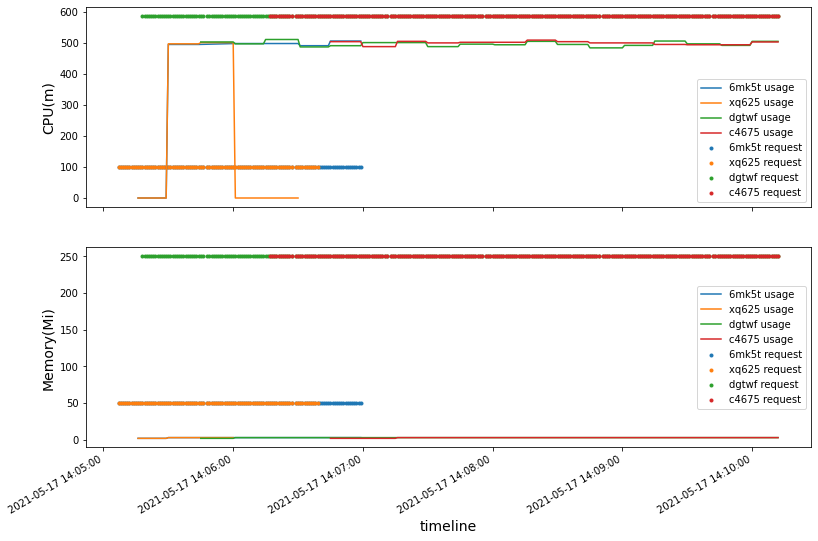

In [225]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13,9))
for i in pod_request:
    ax1.scatter(pod_request[i].time, pod_request[i].cpu,marker='.',label=i[-5:]+' request')
    ax1.plot(pod_usage[i].time, pod_usage[i].cpu, label=i[-5:] + ' usage')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
ax1.xaxis.set_minor_locator(mdates.MinuteLocator())
ax1.set_ylabel('CPU(m)', fontsize=14)
ax1.set_xlabel('timeline', fontsize=14)
ax1.legend()

for i in pod_request:
    ax2.scatter(pod_request[i].time, pod_request[i].memory,marker='.',label=i[-5:]+' request')
    ax2.plot(pod_usage[i].time, pod_usage[i].memory, label=i[-5:] + ' usage')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
ax2.xaxis.set_minor_locator(mdates.MinuteLocator())
ax2.set_ylabel('Memory(Mi)', fontsize=14)
ax2.set_xlabel('timeline', fontsize=14)
ax2.legend()

fig.autofmt_xdate() #rotate labels
plt.show()